# Stephen King Novel NLP

## Imports

In [1]:
import pandas as pd
import numpy as np
from IPython import display
from pymongo import MongoClient
import os
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import json
from sklearn.externals import joblib
from statsmodels.nonparametric.smoothers_lowess import lowess

display.clear_output(wait=True)
from config import user_name,password,ip
from epub_conversion.utils import open_book

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt, mpld3
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 20, 10

## Stoplist

In [2]:
stoplist = stopwords.words('english')
stoplist += ['.', ',', '(', ')', "'", '"']
#stoplist = set(stoplist)

## Import Sentiment

In [3]:
sentDF = pd.read_pickle('sentiment.pkl')

## Functions

### Manual Word Count

In [4]:
def clean_text(row):
    text = row['content'].lower()
    text = text.strip('\n')
    return text

### Cleanup

In [5]:
def cleanup(token, lower = True):
    if lower:
       token = token.lower()
    return token.strip()

### Entity Detection

In [6]:
def ie_preprocess(document):
    document = ' '.join([i for i in document.split() if i not in stoplist])
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences

In [7]:
def extract_names(document):
    names = []
    sentences = ie_preprocess(document)
    for tagged_sentence in sentences:
        for chunk in nltk.ne_chunk(tagged_sentence):
            if type(chunk) == nltk.tree.Tree:
                if chunk.label() == 'PERSON':
                    names.append(' '.join([c[0] for c in chunk]))
    return names

### Tokenize and Stem

In [8]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [9]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

### Sentiment

In [10]:
def a_sentiment(filename):
    with open (filename, "r") as myfile:
        text=myfile.read().replace('\n', ' ')
        blob = TextBlob(text)       
        tot = 0.0
        sent = []        
        afinn = Afinn()
        for sentence in blob.sentences:            
            senti = afinn.score(str(sentence))        
            sent.append(senti)   
        return sent

### Sentiment Plot

In [11]:
def sentiplot(filename, title):
    fig = plt.figure()
    sent= a_sentiment(filename)    
    plt.plot(sent,label=title)
    plt.ylabel("Cumulative Emotional Valence")
    plt.xlabel("Sentence #")    
    plt.legend()


### Plot Stories

In [12]:
def plot_story(title,df=sentDF,f=.1,d=0.0):
    bookDF = df.loc[df['title'] == title]
    sentiment = list(bookDF.sentiment)
    lowX = list(range(1,len(sentiment)+1))
    #print(len(sent),len(lowX))
    low_plot = lowess(sentiment,lowX,frac=.1,return_sorted=False,delta=d)
    #f2 = interp1d(lowX, sentiment, kind='cubic')
    title = title
    #y = np.arange(-1.0,2.0,.1)
    fig = plt.figure()
    plt.plot(low_plot,label=title)
    plt.ylabel("Sentiment Score")
    plt.xlabel("Sentence #")    
    plt.legend()
    plt.savefig('images/'+title+'.svg')
   
    #mpld3.show()
    return

## Data Processing

**Create a dictionary from all books**

In [13]:
book_list = []
book_dict = {}
path = "/Users/xavier/dev/metis/fletcher/books/"
for file in os.listdir(path):
    if file.endswith(".txt"):
        clean_name = file.replace(" - Stephen King.txt","")
        book_dict[clean_name] = open(path+file, "r").read()
        book_list.append(clean_name)

In [14]:
# Insert the books into mongo db
clean_list = []
for k,v in book_dict.items():
    try:
        year = re.search("[Cc]opyright ©\s*.*_*(\d{4}).*Stephen King|[Cc]opyright ©\s.*Stephen King.*_*(\d{4})|[Cc]opyright ©\s*.*_*(\d{4}).*Richard Bachman|[Cc]opyright ©\s.*Richard Bachman.*_*(\d{4})",v).group(0) # get copyright year from book text
        year = re.search("(\d{4})",year).group(0)
    except:
        year = ""
    try:
        isbn = re.search(".*ISBN+:*(\d*.*)",v)[1].split(" ")
        isbn = max(isbn, key=len)
    except:
        isbn = ""
    try:
        start = v.find('******start_of_file******')+25
        end = v.find('******end_of_file******')
        text = v[start:end]
    except:
        text = ""
        
    doc = {"title":k,"year":year,'isbn':isbn,"content":text}
    clean_list.append(doc)
    #print(doc['title'],doc['isbn'])
    #print(doc['title'],doc['year'])
    #db.books.insert_one(doc)

In [15]:
df = pd.DataFrame(clean_list)

In [16]:
df.to_pickle('books.pkl')

### Import Pickle

In [17]:
df = pd.read_pickle('books.pkl')

In [18]:
df.columns.tolist()

['content', 'isbn', 'title', 'year']

In [19]:
df.head()

,content,isbn,title,year
0,d by “Duel”\n\nJoe Hill and Stephen King\n\n\n...,9780062215956,Throttle,2009
1,TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nIntr...,978-0-385-52884-9,Night Shift,1976
2,this Scribner eBook.\n\n\n\n* * *\n\n\n\nSign...,0-7432-0467-0,Riding the Bullet,2000
3,Page\n\nCopyright Page\n\nDedication\n\n\n\n\...,978-1-101-13813-7,Roadwork,1981
4,dication\n\nIntroduction\n\nAuthor’s Note\n\n\...,978-0-385-52822-1,Salem's Lot,1975


In [20]:
document = df.iloc[28]['content']

In [21]:
# df['content'] = df.content.apply(lambda x: x.lower())
# df['content'] = df.content.apply(lambda x: x.strip("\n"))

### Character extraction test

In [22]:
characters = extract_names(document)

In [23]:
characters[:10]

['Page',
 'Copyright Page',
 'Stephen King',
 'Prince Peter',
 'Flagg',
 'Thomas',
 'Peter',
 'Stephen',
 'Stephen King',
 'Penguin Group']

In [24]:
characters = [s.split(" ") for s in characters]

In [25]:
flat_list = [item for sublist in characters for item in sublist]

In [26]:
flat_list[:10]

['Page',
 'Copyright',
 'Page',
 'Stephen',
 'King',
 'Prince',
 'Peter',
 'Flagg',
 'Thomas',
 'Peter']

In [27]:
characters = set(flat_list)
characters = list(characters)

In [28]:
stoplist = list(stoplist)
stoplist.extend(characters)
stoplist = set(stoplist)

### Word Tokenize

In [29]:
# df['content'] = df.content.apply(lambda x: word_tokenize(x))

In [30]:
# df.head()

### Omit Stop Words

In [31]:
df['content'] = df.content.apply(lambda x: [word for word in x if word not in stoplist])

In [32]:
df.head()

,content,isbn,title,year
0,"[ , b, , “, D, u, e, l, ”, \n, \n, J, e, , H...",9780062215956,Throttle,2009
1,"[T, S, \n, \n, \n, \n, C, v, e, r, , P, g, e,...",978-0-385-52884-9,Night Shift,1976
2,"[ , h, , S, c, r, b, n, e, r, , e, B, k, \n,...",0-7432-0467-0,Riding the Bullet,2000
3,"[ , P, g, e, \n, \n, C, p, r, g, h, , P, g, e...",978-1-101-13813-7,Roadwork,1981
4,"[c, n, \n, \n, I, n, r, u, c, n, \n, \n, A, u,...",978-0-385-52822-1,Salem's Lot,1975


### Convert tokens back to a long string

In [33]:
df['content'] = df.content.apply(lambda x: " ".join(x))

In [34]:
df.head()

,content,isbn,title,year
0,b “ D u e l ” \n \n J e H l l n S e ...,9780062215956,Throttle,2009
1,T S \n \n \n \n C v e r P g e \n \n T l e ...,978-0-385-52884-9,Night Shift,1976
2,h S c r b n e r e B k \n \n \n \n * * ...,0-7432-0467-0,Riding the Bullet,2000
3,P g e \n \n C p r g h P g e \n \n D e c n ...,978-1-101-13813-7,Roadwork,1981
4,c n \n \n I n r u c n \n \n A u h r ’ N e \n...,978-0-385-52822-1,Salem's Lot,1975


### Sentence Tokenize

In [35]:
df['content'] = df.content.apply(lambda x: sent_tokenize(x))

In [36]:
df.head()

,content,isbn,title,year
0,[ b “ D u e l ” \n \n J e H l l n S e...,9780062215956,Throttle,2009
1,[T S \n \n \n \n C v e r P g e \n \n T l e ...,978-0-385-52884-9,Night Shift,1976
2,[ h S c r b n e r e B k \n \n \n \n * *...,0-7432-0467-0,Riding the Bullet,2000
3,[ P g e \n \n C p r g h P g e \n \n D e c n...,978-1-101-13813-7,Roadwork,1981
4,[c n \n \n I n r u c n \n \n A u h r ’ N e \...,978-0-385-52822-1,Salem's Lot,1975


### Stem Words

In [37]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [38]:
df['content'] = df.content.apply(lambda x: [stemmer.stem(word) for word in x])

In [39]:
df.head()

,content,isbn,title,year
0,[ b “ d u e l ” \n \n j e h l l n s e...,9780062215956,Throttle,2009
1,[t s \n \n \n \n c v e r p g e \n \n t l e ...,978-0-385-52884-9,Night Shift,1976
2,[ h s c r b n e r e b k \n \n \n \n * *...,0-7432-0467-0,Riding the Bullet,2000
3,[ p g e \n \n c p r g h p g e \n \n d e c n...,978-1-101-13813-7,Roadwork,1981
4,[c n \n \n i n r u c n \n \n a u h r ' n e \...,978-0-385-52822-1,Salem's Lot,1975


In [40]:
titles = df.title

In [41]:
books = df.content

In [42]:
books[4][:500]

["c n \n \n i n r u c n \n \n a u h r '   n e \n \n \n \n ' s a l e m ' s   l o t \n \n \n \n p r l g u e \n \n p r   o n e \n \n t h e   m r e n   h u e \n \n c h p e r   o n e   b e n   i \n \n c h p e r   t w   s u n   i \n \n c h p e r   t h r e e   t h e   l   i \n \n c h p e r   f u r   d n n   g l c k   n   o h e r \n \n c h p e r   f v e   b e n   i i \n \n c h p e r   s x   t h e   l   i i \n \n c h p e r   s e v e n   m \n \n p r   t w \n \n t h e   e p e r r   f   i c e   c r e \n \n c h p e r   e g h   b e n   i i i \n \n c h p e r   n n e   s u n   i i \n \n c h p e r   t e n   t h e   l   i i i \n \n c h p e r   e l e v e n   b e n   i v \n \n c h p e r   t w e l v e   m r k \n \n c h p e r   t h r e e n   f h e r   c l l h n \n \n p r   t h r e e \n \n t h e   d e e r e   v l l g e \n \n c h p e r   f u r e e n   t h e   l   i v \n \n c h p e r   f f e e n   b e n   n   m r k \n \n e p l g u e \n \n \n \n o n e   f r   h e   r \n \n j e r u l e '   l \n \n d e l e e   s 

### Lower Stop List

In [43]:
stoplist = [x.lower() for x in stoplist]

### Convert sentences to Rows

In [44]:
s = df.apply(lambda x: pd.Series(x['content']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'content'
sentDF = df.drop('content', axis=1).join(s)

In [45]:
sentDF.head()

,isbn,title,year,content
0,9780062215956,Throttle,2009,b “ d u e l ” \n \n j e h l l n s e ...
0,9780062215956,Throttle,2009,c l r k e ' g n e s ' h e n e t h e ...
0,9780062215956,Throttle,2009,” \n \n “ c l r k e ' e r ” \n \n “ w h w ...
0,9780062215956,Throttle,2009,” \n \n “ f r h e n e c e u h n ' ...
0,9780062215956,Throttle,2009,y u e e c l r k e h n g n g u p h e ...


In [46]:
cujoDF = sentDF.loc[sentDF['title'] == 'Cujo']

In [47]:
cujoDF

,isbn,title,year,content
60,978-1-101-13806-9,Cujo,1981,p g e \n \n c p r g h p g e \n \n d e c n ...
60,978-1-101-13806-9,Cujo,1981,” f r h e e r — h h e r \n \n t h e ...
60,978-1-101-13806-9,Cujo,1981,” \n \n a n h e n h w n h e b e ...
60,978-1-101-13806-9,Cujo,1981,” h k e h g n \n \n “ t h e r e w ...
60,978-1-101-13806-9,Cujo,1981,” t c r e “ i n c l e !
60,978-1-101-13806-9,Cujo,1981,” a n h e b u r n e r \n \n h ...
60,978-1-101-13806-9,Cujo,1981,” \n \n “ y e ” t n h e n f r c e ...
60,978-1-101-13806-9,Cujo,1981,” \n \n “ r e l l ” h “ n w i w n ...
60,978-1-101-13806-9,Cujo,1981,” \n \n s h e w e n n n h e w c h ...
60,978-1-101-13806-9,Cujo,1981,y u h v e g ” \n \n r e g n e t n ...


In [48]:
books = sentDF.content

### Processing Sentences

In [49]:
# totalvocab_stemmed = []
# totalvocab_tokenized = []
# for i in books:
#     allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
#     totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
#     allwords_tokenized = tokenize_only(i)
#     totalvocab_tokenized.extend(allwords_tokenized)

In [50]:
# totalvocab_stemmed

In [51]:
titles = sentDF.title
#titles

In [52]:
len(books)

110219

In [53]:
sentDF.head()

,isbn,title,year,content
0,9780062215956,Throttle,2009,b “ d u e l ” \n \n j e h l l n s e ...
0,9780062215956,Throttle,2009,c l r k e ' g n e s ' h e n e t h e ...
0,9780062215956,Throttle,2009,” \n \n “ c l r k e ' e r ” \n \n “ w h w ...
0,9780062215956,Throttle,2009,” \n \n “ f r h e n e c e u h n ' ...
0,9780062215956,Throttle,2009,y u e e c l r k e h n g n g u p h e ...


## Sentiment Analysis

In [54]:
dfRaw = pd.read_pickle('books.pkl')

In [55]:
#Cujo Test
cujo = dfRaw.loc[dfRaw['title'] == 'Cujo']

In [56]:
cujo.to_pickle('cujodf.pkl')

In [57]:
cujo.content

60     Page\n\nCopyright Page\n\nDedication\n\n\n\n\...
Name: content, dtype: object

In [58]:
TextBlob(str(cujo.content)).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [59]:
cujoDF['sentiment'] = cujoDF.content.apply(lambda x: TextBlob(x).sentiment[0])

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
sentDF['sentiment'] = sentDF.content.apply(lambda x: TextBlob(x).sentiment[0])

In [61]:
sentDF.to_pickle('sentiment.pkl')

In [62]:
sentDF.head()

,isbn,title,year,content,sentiment
0,9780062215956,Throttle,2009,b “ d u e l ” \n \n j e h l l n s e ...,0.0
0,9780062215956,Throttle,2009,c l r k e ' g n e s ' h e n e t h e ...,0.0
0,9780062215956,Throttle,2009,” \n \n “ c l r k e ' e r ” \n \n “ w h w ...,0.0
0,9780062215956,Throttle,2009,” \n \n “ f r h e n e c e u h n ' ...,0.0
0,9780062215956,Throttle,2009,y u e e c l r k e h n g n g u p h e ...,0.0


### Smoothing

/Users/xavier/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xavier/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


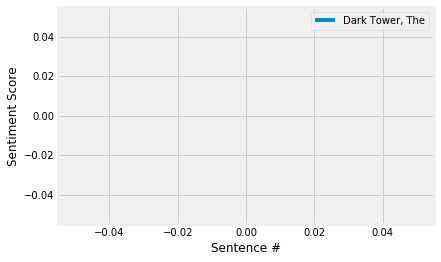

In [63]:
plot_story('Dark Tower, The',sentDF)

/Users/xavier/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xavier/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


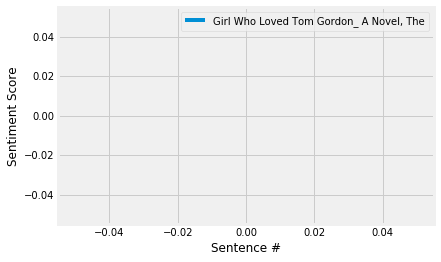

In [64]:
plot_story('Girl Who Loved Tom Gordon_ A Novel, The',sentDF)

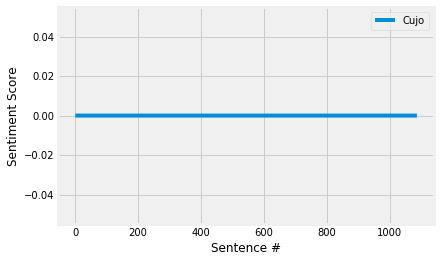

In [65]:
plot_story('Cujo',sentDF)

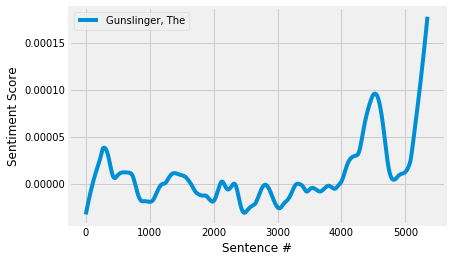

In [66]:
plot_story('Gunslinger, The')

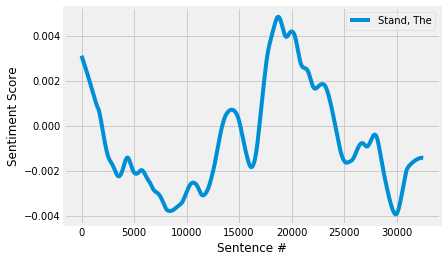

In [67]:
plot_story('Stand, The')

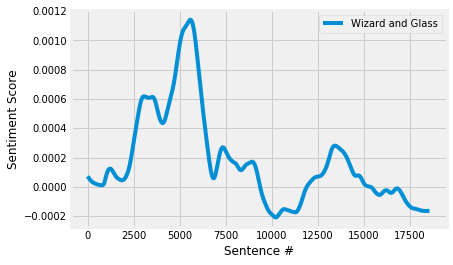

In [68]:
plot_story('Wizard and Glass')

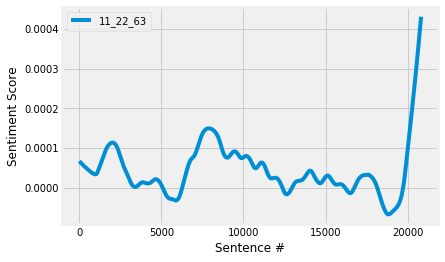

In [69]:
plot_story('11_22_63')

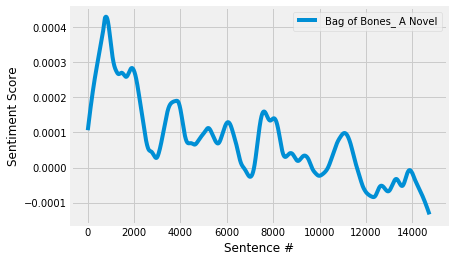

In [70]:
plot_story('Bag of Bones_ A Novel')

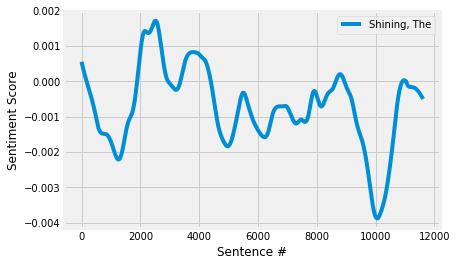

In [71]:
plot_story('Shining, The')

### Novel Sentiment Average

In [72]:
sentGroup = sentDF.groupby(['title','year']).sentiment.mean().reset_index()
sentGroup.sort_values('sentiment',ascending=False,inplace=True)

In [73]:
year = sentDF.year

In [74]:
#sentGroup.merge(pd.DataFrame(data = [year.values] * len(year), columns = year.index),how=left, left_index=True, right_index=True)

In [75]:
sentGroup.head()

,title,year,sentiment
4,Blockade Billy,2010,0.017742
67,the_girl_who_loved_tom_gordon.txt,1999,0.017236
37,Mile 81,2011,0.017127
34,Just After Sunset_ Stories,2008,0.010101
25,Gerald's Game,1992,0.008687


## mpld3 Test

In [76]:
mpld3.enable_notebook()

In [77]:
def plot_d3(title,df=sentDF,f=.1,d=0.0):
    bookDF = df.loc[df['title'] == title]
    sentiment = list(bookDF.sentiment)
    lowX = list(range(1,len(sentiment)+1))
    #print(len(sent),len(lowX))
    low_plot = lowess(sentiment,lowX,frac=.1,return_sorted=False,delta=d)
    fig = plt.figure()
    plt.plot(low_plot,label=title)
    plt.ylabel("Sentiment Score")
    plt.xlabel("Sentence #")    
    plt.legend()
#     plt.savefig('images/'+title+'.svg')
    mpld3.show()
    p = mpld3.fig_to_d3(fig)
    return p